# Salary Prediction Project Pt 2: 
# Model Development, Deployment, and Interpretation

In this notebook, we develop a model to predict salaries.

The focus is on **interpretability** : therefore, we mostly try to build a linear model and look at its residuals to identify hidden interactions rather than use the kind of techniques that win Kaggle competitions like ensembling lots of different models. 

Nevertheless, we compare our linear model's predictions with those produced by XGBoost to see how our model is doing.

As you will see in this notebook, **we are able to reduce the Mean Squared Error of the model from 384 to 355 with feature engineering** based on interactions. Furthermore, we demonstrate that **our linear model** with a limited number of features **performs better than XGBoost** on the data set.

#### We can therefore say with confidence that our linear model explains all of the variation in salaries that can be explained.

### Importing libraries and loading data, and splitting into training and validation  set

In [88]:
#importing libraries
import numpy as np
import pandas as pd
from statsmodels.api import OLS
import patsy

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score

import xgboost as xgb

import gc

from Salary_pred_EDA_helpers import make_valid_training, make_all_boxplots

from Salary_pred_model_helpers import *

In [2]:
valid_training = make_valid_training()

valid_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   jobId                999995 non-null  object
 1   companyId            999995 non-null  object
 2   jobType              999995 non-null  object
 3   degree               999995 non-null  object
 4   major                999995 non-null  object
 5   industry             999995 non-null  object
 6   yearsExperience      999995 non-null  int64 
 7   milesFromMetropolis  999995 non-null  int64 
 8   salary               999995 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


#### Splitting the data into a training and validation set

We need to do this because afterwards, we're going to encode some features which are directly related to the target variable. 
Note that the actual test set doesn't have any salary information, so the only way to measure our prediction accuracy is through a validation set. 

Using cross validation is dangerous when we encode these types of features, as the way we develop the features could lead us to have a false confidence in our predictions due to data leakage.

In [3]:
y, X = isolate_target(valid_training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 27314)

#### Recombining predictors and target into a single dataframe 

This will be necessary for feature engineering and residual analysis.

In [4]:
train_df = pd.concat([X_train, y_train], axis = 1)
test_df = pd.concat([X_test, y_test], axis = 1)

## Linear Models
### First linear model: using just the small categorical variables

For now, we will ignore the company_ID column in our linear model, because it has too many unique values.

We do not take the standard approach of creating dummy variables with pd.get_dummies and fitting the model with sklearn.linear_model, because using patsy enables us to more quickly encode variable interactions or take out variables from our model.

Furthermore, statsmodels OLS is preferred to sklearn.linear_model because its summary method enables us to have more detailed information on our model's coefficients.

In [5]:
equation0 = 'salary ~ jobType + degree + major + industry + yearsExperience + milesFromMetropolis'
y_train, X_train = patsy.dmatrices(equation0, data = train_df)
y_test, X_test = patsy.dmatrices(equation0, data = test_df)

In [6]:
lin_reg = OLS(y_train, X_train)
lin_regf = lin_reg.fit()

In [7]:
lin_regf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                 8.595e+04
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:10:34   Log-Likelihood:            -3.5157e+06
No. Observations:              799996   AIC:                         7.031e+06
Df Residuals:                  799968   BIC:                         7.032e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   134.9982      0.138    979.828      0.000     134.728     135.268
jobType[T.CFO]               -9.8806      0.088   -112.589      0.000     -10.053      -9.709
jobType[T.CTO]               -9.8477      0.088   -112.317      0.000     -10.020      -9.676
jobType[T.JANITOR]          -62.3796      0.092   -675.597      0.000     -62.561     -62.199
jobType[T.JUNIOR]           -49.8236      0.088   -567.591      0.000     -49.996     -49.652
jobType[T.MANAGER]          -29.8459      0.088   -340.526      0.000     -30.018     -29.674
jobType[T.SENIOR]           -39.8027      0.088   -454.726      0.000     -39.974     -39.631
jobType[T.VICE_PRESIDENT]   -19.9601      0.088   -227.891      0.000     -20.132     -19.788
degree[T.DOCTORAL]           10.0391      0.074    135.684      0.000       9.894      10.184
degree[T.HIGH_SCHOOL]        -5.7859      0.111    -51.902      0.000      -6.004      -5.567
degree[T.MASTERS]             4.9756      0.074     67.214      0.000       4.831       5.121
degree[T.NONE]               -9.4923      0.112    -85.130      0.000      -9.711      -9.274
major[T.BUSINESS]             7.6520      0.128     59.630      0.000       7.400       7.904
major[T.CHEMISTRY]            0.9986      0.128      7.802      0.000       0.748       1.249
major[T.COMPSCI]              4.0164      0.128     31.327      0.000       3.765       4.268
major[T.ENGINEERING]         10.6320      0.128     82.973      0.000      10.381      10.883
major[T.LITERATURE]          -3.6733      0.128    -28.647      0.000      -3.925      -3.422
major[T.MATH]                 5.0462      0.129     39.238      0.000       4.794       5.298
major[T.NONE]                -4.9610      0.128    -38.677      0.000      -5.212      -4.710
major[T.PHYSICS]              2.2841      0.128     17.810      0.000       2.033       2.536
industry[T.EDUCATION]       -10.0588      0.082   -122.629      0.000     -10.220      -9.898
industry[T.FINANCE]          21.1753      0.082    258.162      0.000      21.015      21.336
industry[T.HEALTH]            6.1816      0.082     75.331      0.000       6.021       6.342
industry[T.OIL]              21.2653      0.082    259.266      0.000      21.105      21.426
industry[T.SERVICE]          -4.9978      0.082    -60.911      0.000      -5.159      -4.837
industry[T.WEB]              12.1042      0.082    147.660      0.000      11.944      12.265
yearsExperience               2.0085      0.003    660.877      0.000       2.003       2.014
milesFromMetropolis          -0.3993      0.001   -526.134      0.000      -0.401      -0.398
==============================================================================
Omnibus:                     6013.564   Durbin-Watson:                   2.000
Prob(Omnibu

Our most basic linear model has an R-squared value of .744, which means the model can explain 74% of the variation in salaries based on the predictors that it has; let's see how this model performs on the test set.

In [8]:
mse(y_train, lin_regf.predict(X_train))

384.31800444758403

In [9]:
mse(y_test, lin_regf.predict(X_test))

384.64698798534414

We can see that this model is robust: it does almost as well predicting the test set as the training set; it's probably underfitting, as we haven't yet engineered any features, but it's definitely not overfitting. 

We will now look at the model's residuals, to try to see what features should be engineered.

### Looking at the residuals of the first linear model

In [10]:
train_df['base_OLS_residuals'] = lin_regf.resid

train_df['base_OLS_residuals'].max()

94.72279612644596

In [11]:
train_df['base_OLS_residuals'].min()

-67.65694620674259

In [12]:
np.abs(train_df['base_OLS_residuals']).mean()

15.847365233837374

We can see that the model has made some huge errors: one salary is underestimated by over $94,000 USD.

The mean absolute error of the model is a bit less than $16,000 dollars.

#### What part of residual errors does the company ID explain?

In [13]:
company_errors = train_df.groupby('companyId').base_OLS_residuals.mean()
company_errors.min()

-0.3471968611223991

In [14]:
company_errors.max()

0.42256312859734585

In [15]:
np.abs(company_errors).mean()

0.13606180055683803

By itself, the company ID doesn't add much prediction value: there are no companies that consistently pay high salaries or low salaries inside the database. This means that the companyId won't add anything to a linear model.

We can verify this by looking at what happens when we include companyId in the equation.

In [16]:
equation1 = equation0 + '+ companyId'
y1_train, X1_train = patsy.dmatrices(equation1, data = train_df)
y1_test, X1_test = patsy.dmatrices(equation1, data = test_df)

In [17]:
lin_reg1 = OLS(y1_train, X1_train)
lin_reg1f = lin_reg1.fit()
lin_reg1f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                 2.608e+04
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:11:45   Log-Likelihood:            -3.5157e+06
No. Observations:              799996   AIC:                         7.032e+06
Df Residuals:                  799906   BIC:                         7.033e+06
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   135.0859      0.222    609.023      0.000     134.651     135.521
jobType[T.CFO]               -9.8799      0.088   -112.576      0.000     -10.052      -9.708
jobType[T.CTO]               -9.8453      0.088   -112.285      0.000     -10.017      -9.673
jobType[T.JANITOR]          -62.3788      0.092   -675.553      0.000     -62.560     -62.198
jobType[T.JUNIOR]           -49.8224      0.088   -567.553      0.000     -49.994     -49.650
jobType[T.MANAGER]          -29.8443      0.088   -340.495      0.000     -30.016     -29.673
jobType[T.SENIOR]           -39.8019      0.088   -454.706      0.000     -39.974     -39.630
jobType[T.VICE_PRESIDENT]   -19.9592      0.088   -227.872      0.000     -20.131     -19.788
degree[T.DOCTORAL]           10.0404      0.074    135.698      0.000       9.895      10.185
degree[T.HIGH_SCHOOL]        -5.7837      0.111    -51.881      0.000      -6.002      -5.565
degree[T.MASTERS]             4.9766      0.074     67.225      0.000       4.831       5.122
degree[T.NONE]               -9.4910      0.112    -85.116      0.000      -9.710      -9.272
major[T.BUSINESS]             7.6527      0.128     59.634      0.000       7.401       7.904
major[T.CHEMISTRY]            0.9971      0.128      7.790      0.000       0.746       1.248
major[T.COMPSCI]              4.0171      0.128     31.331      0.000       3.766       4.268
major[T.ENGINEERING]         10.6325      0.128     82.973      0.000      10.381      10.884
major[T.LITERATURE]          -3.6721      0.128    -28.637      0.000      -3.923      -3.421
major[T.MATH]                 5.0461      0.129     39.236      0.000       4.794       5.298
major[T.NONE]                -4.9609      0.128    -38.675      0.000      -5.212      -4.710
major[T.PHYSICS]              2.2842      0.128     17.810      0.000       2.033       2.536
industry[T.EDUCATION]       -10.0583      0.082   -122.618      0.000     -10.219      -9.898
industry[T.FINANCE]          21.1753      0.082    258.150      0.000      21.015      21.336
industry[T.HEALTH]            6.1806      0.082     75.316      0.000       6.020       6.341
industry[T.OIL]              21.2643      0.082    259.242      0.000      21.104      21.425
industry[T.SERVICE]          -4.9981      0.082    -60.911      0.000      -5.159      -4.837
industry[T.WEB]              12.1033      0.082    147.643      0.000      11.943      12.264
companyId[T.COMP1]           -0.2569      0.248     -1.037      0.300      -0.742       0.229
companyId[T.COMP10]           0.0149      0.246      0.061      0.952      -0.468       0.498
companyId[T.COMP11]           0.0861      0.247      0.349      0.727      -0.398       0.570
companyId[T.COMP12]          -0.1593      0.248     -0.643      0.520      

The summary of the model fit above confirms what we saw from looking at residuals by company: the model which includes companyId has exactly the same R-squared as the one that doesn't. Furthermore, none of the coefficients for companies are statistically significant.

#### Could the relationship between salary and years experience or miles from metropolis be non linear?

It's possible that these variables would have a non linear relationship with salaries, even though it didn't look that way from our EDA. Let's check this by looking at the residuals of the model.

In [18]:
train_df.groupby('yearsExperience').base_OLS_residuals.mean()

yearsExperience
0     0.094055
1    -0.106036
2     0.071590
3     0.083283
4     0.025304
5    -0.075751
6    -0.019720
7     0.003934
8    -0.137294
9     0.017638
10   -0.112965
11    0.022806
12    0.063020
13    0.019028
14   -0.007212
15   -0.056607
16    0.108599
17   -0.059660
18    0.131707
19   -0.005094
20   -0.113164
21   -0.027305
22    0.094430
23    0.080683
24   -0.093842
Name: base_OLS_residuals, dtype: float64

The mean of residuals is very small for all values of years experience, and there is no increasing or decreasing trend, so a linear model seems well adapted to this relationship. 

Now we'll check if the same applies to distance; however, to do so, we need to bin the distance variable.

In [19]:
#we create the bins using qcut, but cut the data using cut with wider bins at the extremities; this ensures that the data
#in the training set and test set are cut the same way: thanks to ALollz on stack overflow for this tip

qbinned_distance, dist_bins = pd.qcut(train_df['milesFromMetropolis'], 5, retbins = True)
dist_bins = np.concatenate(([-0.001], dist_bins[1:-1], [99.001]))

In [20]:
train_df['binned_distance'] = pd.cut(train_df['milesFromMetropolis'], bins = dist_bins)

test_df['binned_distance'] = pd.cut(test_df['milesFromMetropolis'], bins = dist_bins)

In [21]:
train_df.groupby('binned_distance').base_OLS_residuals.mean()

binned_distance
(-0.001, 20.0]    0.070275
(20.0, 40.0]     -0.092018
(40.0, 60.0]     -0.022222
(60.0, 80.0]      0.041099
(80.0, 99.001]   -0.000660
Name: base_OLS_residuals, dtype: float64

The linear model also seems well adapted for predicting the impact of distance on salaries. 

We will now look at interactions between two variables. Before we start this, we'll also bin the years experience column, so that fewer interactions need to be considered.

In [22]:
qbinned_experience, exp_bins = pd.qcut(train_df['yearsExperience'], 5, retbins = True)
exp_bins = np.concatenate(([-0.001], exp_bins[1:-1], [99]))

In [23]:
train_df['binned_experience'] = pd.cut(train_df['yearsExperience'], bins = exp_bins)
test_df['binned_experience'] = pd.cut(test_df['yearsExperience'], bins = exp_bins)

### Residuals linked to variable interactions:

Our helper function identify_interactions will automatically identify any pair of variables for which errors are high.

In [24]:
grouping_columns = ['companyId', 'jobType', 'degree', 'major', 'industry', 'binned_distance', 'binned_experience']

In [25]:
interesting_interactions = identify_interactions(train_df, grouping_columns, 'base_OLS_residuals')

companyId and jobType shows interesting interactions, explore further
companyId and degree shows interesting interactions, explore further
companyId and major shows interesting interactions, explore further
companyId and industry shows interesting interactions, explore further
companyId and binned_distance shows interesting interactions, explore further
companyId and binned_experience shows interesting interactions, explore further
jobType and degree shows interesting interactions, explore further
jobType and major showed no interesting interactions
jobType and industry shows interesting interactions, explore further
jobType and binned_distance showed no interesting interactions
jobType and binned_experience showed no interesting interactions
degree and major showed no interesting interactions
degree and industry shows interesting interactions, explore further
degree and binned_distance showed no interesting interactions
degree and binned_experience showed no interesting interactions
m

In [26]:
for an_interaction in interesting_interactions:
    get_nlargest_interactions(train_df, an_interaction, 'base_OLS_residuals')

5 largest absolute residual errors for interaction between companyId and jobType
companyId  jobType
COMP62     CEO        1.753015
           MANAGER    1.504025
COMP61     CEO        1.373368
COMP18     CTO        1.300530
COMP60     CEO        1.285513
Name: base_OLS_residuals, dtype: float64


5 largest absolute residual errors for interaction between companyId and degree
companyId  degree   
COMP36     DOCTORAL     1.532623
COMP31     DOCTORAL     1.406375
COMP47     BACHELORS    1.194288
COMP28     BACHELORS    1.166060
COMP53     DOCTORAL     1.020120
Name: base_OLS_residuals, dtype: float64


5 largest absolute residual errors for interaction between companyId and major
companyId  major      
COMP10     ENGINEERING    2.733921
COMP9      LITERATURE     2.474045
COMP60     CHEMISTRY      2.461592
COMP17     COMPSCI        2.325900
COMP20     CHEMISTRY      2.243926
Name: base_OLS_residuals, dtype: float64


5 largest absolute residual errors for interaction between companyId and 

Some interesting results come out of this: 

Company Id has significant interactions with every other variable. However, we need to be conservative in how we encode this: we cannot create a dummy variable for every company and every other variable, as this would make our dataframe huge.

- CEO positions tend to have the highest residual errors when we look at the interaction between CEO and company: this is not surprising, hiring a CEO is an important decision and different companies might have different policies for this. We know that our linear model is properly fit, and that the mean residual error for CEO positions is 0, so we need to add a variable that takes into account the salary of CEOs in the company compared to other positions

- The interaction between company ID and degree is more difficult to interpret: it makes sense that the highest differences would be for PhDs, but less sense that there would be significant residuals for people with bachelors

- The residual errors for the interaction between company ID and major is very large, we need to look more deeply into this.

- The interaction between company ID and industry seems to be mostly significant in the health sector, we'll look into that

- Residual errors for interactions between company ID and binned distance, and for interactions between company ID and binned experience, are the largest for short distances and lots of experience, respectively; these correspond to the highest paid positions

Other interesting interactions: 
- residual errors for the interaction  janitors, having studied in high school adds less to the salary than the model would expect; otherwise, the errors are small; the largest absolute errors are all for a high school or no degree
- the expected differences in salaries between industries, with lower salaries in the auto, education and service industries and higher salaries in the oil, web, health and finance sectors don't have the same impact on janitors' salaries as on the other categories
- degrees have different impact in the web industry than in other industries

**By far, the most important thing that we identify is the huge interaction between major and industry: the absolute value of the residuals is out of proportion with the rest; most others are less than 2, here we have errors of more than 10.**

Distance and Experience also interact in a way that our model did not manage to capture effectively.

#### Interaction between major and industry

In [27]:
major_industry_interaction = train_df.groupby(['major', 'industry']).base_OLS_residuals.mean()

major_industry_interaction.nlargest(10)

major        industry 
BUSINESS     FINANCE      14.402668
CHEMISTRY    HEALTH       12.351670
BIOLOGY      HEALTH       12.114634
MATH         WEB          11.633482
ENGINEERING  OIL          11.147003
             WEB           9.746315
LITERATURE   EDUCATION     9.524849
PHYSICS      WEB           7.188496
BUSINESS     SERVICE       4.612936
             OIL           3.714225
Name: base_OLS_residuals, dtype: float64

In [28]:
major_industry_interaction.nsmallest(10)

major        industry 
ENGINEERING  HEALTH      -8.809137
             SERVICE     -7.771109
BUSINESS     WEB         -7.392696
ENGINEERING  EDUCATION   -7.322817
BUSINESS     HEALTH      -6.016364
             AUTO        -4.855986
             EDUCATION   -4.652431
CHEMISTRY    WEB         -3.250837
LITERATURE   WEB         -3.000271
MATH         FINANCE     -2.916480
Name: base_OLS_residuals, dtype: float64

We can see that basically, the interaction between major and industry leads to residuals with a positive value when the major is highly relevant to the industry, like a business degree for finance, a chemistry degree for health, or an engineering degree for oil; in this case, the interaction is more than the sum of its parts, so the model underestimates the salaries on the contrary, when the major is irrelevant to the industry, real salaries are lower than predicted salaries, because the full value of the major is not used in this industry.

We can also see that there are at least 20 interactions with an absolute value higher than 2.8, which is more than what we've seen for any of the other relationships apart from distance and experience; with so many meaningful interactions, it makes sense to put all possible interactions in our model.

Before we move on to encoding, let's see if we should also encode the relationship between distance and experience, and how.

#### Interaction between distance and experience

In [29]:
distance_experience_interaction = train_df.groupby(['binned_distance', 'binned_experience']).base_OLS_residuals.mean()

distance_experience_interaction.nlargest(10)

binned_distance  binned_experience
(80.0, 99.001]   (-0.001, 4.0]        8.069599
(-0.001, 20.0]   (19.0, 99.0]         7.780330
                 (14.0, 19.0]         4.227714
(60.0, 80.0]     (-0.001, 4.0]        4.140447
(80.0, 99.001]   (4.0, 9.0]           3.958456
(20.0, 40.0]     (19.0, 99.0]         3.805603
(60.0, 80.0]     (4.0, 9.0]           2.030265
(20.0, 40.0]     (14.0, 19.0]         1.665432
(-0.001, 20.0]   (9.0, 14.0]          0.212465
(40.0, 60.0]     (-0.001, 4.0]        0.132779
Name: base_OLS_residuals, dtype: float64

In [30]:
distance_experience_interaction.nsmallest(10)

binned_distance  binned_experience
(80.0, 99.001]   (19.0, 99.0]        -8.104053
(-0.001, 20.0]   (-0.001, 4.0]       -7.891725
(60.0, 80.0]     (19.0, 99.0]        -4.012575
(-0.001, 20.0]   (4.0, 9.0]          -3.933869
(80.0, 99.001]   (14.0, 19.0]        -3.898376
(20.0, 40.0]     (-0.001, 4.0]       -3.586720
(60.0, 80.0]     (14.0, 19.0]        -2.062348
(20.0, 40.0]     (4.0, 9.0]          -1.988562
                 (9.0, 14.0]         -0.339941
(40.0, 60.0]     (19.0, 99.0]        -0.276579
Name: base_OLS_residuals, dtype: float64

This effect is a bit more difficult to interpret:
- salaries for positions that are very far away and require no experience were underestimated by a lot
- salaries for positions that are very close and require a lot of experience were underestimated by a lot
- salaries for positions that are very far away and require a lot of experience were overestimated by a lot
- salaries for positions that are very close and require little experience were overestimated by a lot.

What we can infer from all of this is that for positions far away, experience matters less than for positions that are very close. 

## Linear model 2: 

#### Encoding the two most meaningful interactions as predictors

We'll start by encoding just these two interactions, which have the most impact, and see how our model improves.
Since the number of unique values for each interacting variable is quite small, we can use the brute force method, which consists of simply putting a dummy variable for each unique combination. Patsy will do this encoding automatically.

In [31]:
equation2 = 'salary ~ jobType + degree + major + industry + yearsExperience + milesFromMetropolis + major*industry + binned_distance*binned_experience'
y2_train, X2_train = patsy.dmatrices(equation2, train_df)
y2_test, X2_test = patsy.dmatrices(equation2, test_df)

#### Analysis of the model's predictive power

In [32]:
lin_reg2 = OLS(y2_train, X2_train)
lin_reg2f = lin_reg2.fit()

lin_reg2f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                 2.597e+04
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:13:11   Log-Likelihood:            -3.4849e+06
No. Observations:              799996   AIC:                         6.970e+06
Df Residuals:                  799896   BIC:                         6.971e+06
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================================================================
                                                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                             125.8293      0.267    471.655      0.000     125.306     126.352
jobType[T.CFO]                                                                                                         -9.8948      0.084   -117.174      0.000     -10.060      -9.729
jobType[T.CTO]                                                                                                         -9.8903      0.084   -117.227      0.000     -10.056      -9.725
jobType[T.JANITOR]                                                                                                    -62.4240      0.089   -702.605      0.000     -62.598     -62.250
jobType[T.JUNIOR]                                                                                                     -49.8482      0.084   -590.148      0.000     -50.014     -49.683
jobType[T.MANAGER]                                                                                                    -29.8397      0.084   -353.808      0.000     -30.005     -29.674
jobType[T.SENIOR]                                                                                                     -39.8529      0.084   -473.157      0.000     -40.018     -39.688
jobType[T.VICE_PRESIDENT]                                                                                             -19.9786      0.084   -237.048      0.000     -20.144     -19.813
degree[T.DOCTORAL]                                                                                                     10.0262      0.071    140.824      0.000       9.887      10.166
degree[T.HIGH_SCHOOL]                                                                                                  -5.7717      0.107    -53.807      0.000      -5.982      -5.561
degree[T.MASTERS]                                                                                                       4.9698      0.071     69.766      0.000       4.830       5.109
degree[T.NONE]                                                                                                         -9.4879      0.107    -88.430      0.000      -9.698      -9.278
major[T.BUSINESS]                                                                                                       4.0127      0.328     12.228      0.000       3.369       4.656
major[T.CHEMISTRY]                                                                                                      0.8680      0.326  

We can see that our Rsquared statistic has increased from .744 to .763, which means that we are now able to explain about 2% more of the variance in salaries than before with the new model. We can also see that most of the interaction variables that we have added are variables that have a statistically significant coefficient in the linear model, which means that unlike the companyId variables, they actually change the prediction value in a meaningful way.

Let's now look at the model's mean squared errors on the test set.

In [33]:
mse(y2_test, lin_reg2f.predict(X2_test))

355.5943345699309

In [34]:
mse(y2_train, lin_reg2f.predict(X2_train))

355.7885560613789

The mean squared error has reduced from 384 to less than 356 on both the training and the test set. Furthermore, our model is still completely robust: test set error is even lower than training set error.

#### Examining the residuals of the second model

We now need to see if we can capture any of the other interactions, most of which relate to companyId in a smart way. 
However, this cannot be done as easily as what we just did: we cannot use a brute force approach and creating a dummy variable for each interaction, because this would result in a dataframe with 1M rows and thousands of columns, which would crash our computer.

Therefore, any additional variables we add should be computed in order to summarize the value of the interaction either with a numeric value, or in a limited number of categories.

However, we should first recalculate our residuals, as there values will be different with the new model.

In [35]:
train_df['adv_OLS_resid'] = lin_reg2f.resid

In [36]:
#saving the train_df and test_df dataframes, which are now in their final state
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

In [37]:
new_interesting_interactions = identify_interactions(train_df, grouping_columns, 'adv_OLS_resid')

companyId and jobType shows interesting interactions, explore further
companyId and degree shows interesting interactions, explore further
companyId and major shows interesting interactions, explore further
companyId and industry shows interesting interactions, explore further
companyId and binned_distance shows interesting interactions, explore further
companyId and binned_experience shows interesting interactions, explore further
jobType and degree shows interesting interactions, explore further
jobType and major showed no interesting interactions
jobType and industry showed no interesting interactions
jobType and binned_distance showed no interesting interactions
jobType and binned_experience showed no interesting interactions
degree and major showed no interesting interactions
degree and industry showed no interesting interactions
degree and binned_distance showed no interesting interactions
degree and binned_experience showed no interesting interactions
major and industry showed n

Apart from the interaction between jobType and degree, which we saw above was mainly for janitor positions, there are no interesting interactions left besides the ones that depend on companyId.

In [38]:
for an_interaction in new_interesting_interactions:
    get_nlargest_interactions(train_df, an_interaction, 'adv_OLS_resid')

5 largest absolute residual errors for interaction between companyId and jobType
companyId  jobType
COMP62     CEO        1.708988
           MANAGER    1.583305
COMP10     CEO        1.320913
COMP61     CEO        1.268021
COMP30     JUNIOR     1.219335
Name: adv_OLS_resid, dtype: float64


5 largest absolute residual errors for interaction between companyId and degree
companyId  degree   
COMP36     DOCTORAL     1.428470
COMP28     BACHELORS    1.344898
COMP31     DOCTORAL     1.243204
COMP44     MASTERS      1.154482
COMP18     MASTERS      1.052538
Name: adv_OLS_resid, dtype: float64


5 largest absolute residual errors for interaction between companyId and major
companyId  major      
COMP9      LITERATURE     2.584131
COMP17     COMPSCI        2.365853
COMP10     ENGINEERING    2.320776
COMP60     CHEMISTRY      2.302341
COMP34     MATH           2.218167
Name: adv_OLS_resid, dtype: float64


5 largest absolute residual errors for interaction between companyId and industry
compan

### Linear Model 3: Attempting to capture company interactions  
The janitor and degree interaction can be fixed by adding a simple dummy variable for the related degrees.

However, all company interactions need to be encoded in a different way: company id and major, which is obviously a potential source of improvement, is typically one of the relationships that we cannot encode with dummy variables: there are over 60 different companies, and 9 majors, which means dummy variables would be adding overr 500 columns to our decision matrix, or 500 M total cells to our dataframe. 

We can try to solve this problem with mean encodings: for each company-major combination, we will take the mean of the salary in the training set plus some noise; these encodings might not work well for a linear regression model, but they should be helpful for tree based models.

With this strategy, we can also encode all of the other interactions of company with other variables, as we only need one column per type of interaction.

#### Mean encoding of interactions between company and other variables

In [39]:
#we group the training dataframe by each interesting column for interaction and store the resulting series as values in a 
#dictionary, with the name of the column of interest as the key
company_interaction_dict = {}
company_interacting_columns = [interaction[1] for interaction in new_interesting_interactions if interaction[0] == 'companyId']
for acol in company_interacting_columns:
    groups = train_df.groupby(['companyId', acol]).salary
    company_interaction_dict[acol] = groups.mean().rename('company_{}_mean'.format(acol))

In [40]:
#an example of a series within the dictionary
company_interaction_dict['jobType']

companyId  jobType       
COMP0      CEO               145.008866
           CFO               135.638819
           CTO               135.603425
           JANITOR            70.823418
           JUNIOR             96.464031
                                ...    
COMP9      JANITOR            71.183428
           JUNIOR             94.815491
           MANAGER           115.918640
           SENIOR            107.369300
           VICE_PRESIDENT    126.051151
Name: company_jobType_mean, Length: 504, dtype: float64

In [41]:
#adding the mean encoded variable to the training set; we use a copy of the dataframe to work on to prevent errors due to 
#merging
ntrain_df = train_df.copy()

for acol in company_interacting_columns:
    ntrain_df = ntrain_df.merge(company_interaction_dict[acol], on = ['companyId', acol])

In [42]:
#adding the same values to the test set

ntest_df = test_df.copy()

for acol in company_interacting_columns:
    ntest_df = ntest_df.merge(company_interaction_dict[acol], how = 'left', on = ['companyId', acol])

In [43]:
#checking that there are no null values in the test set due to missing keys to merge on 
ntest_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199998
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   salary                          199999 non-null  int64   
 1   jobId                           199999 non-null  object  
 2   companyId                       199999 non-null  object  
 3   jobType                         199999 non-null  object  
 4   degree                          199999 non-null  object  
 5   major                           199999 non-null  object  
 6   industry                        199999 non-null  object  
 7   yearsExperience                 199999 non-null  int64   
 8   milesFromMetropolis             199999 non-null  int64   
 9   binned_distance                 199999 non-null  category
 10  binned_experience               199999 non-null  category
 11  company_jobType_mean            199999 non-null  float64 
 12  co

#### Encoding of the interaction between janitor and education

For this, we use a simple dummy variable based on a concatenation of jobType and degree.

In [44]:
ntrain_df['jobdeg'] = ntrain_df['jobType'] + ntrain_df['degree']
ntrain_df['janitor_none'] = ntrain_df.jobdeg.apply(lambda s: s=='JANITORNONE')

ntrain_df['janitor_hs'] = ntrain_df.jobdeg.apply(lambda s: s == 'JANITORHIGH_SCHOOL')

In [45]:
ntest_df['jobdeg'] = ntest_df['jobType'] + ntest_df['degree']
ntest_df['janitor_none'] = ntest_df.jobdeg.apply(lambda s: s=='JANITORNONE')
ntest_df['janitor_hs'] = ntrain_df.jobdeg.apply(lambda s: s == 'JANITORHIGH_SCHOOL')

In [46]:
equation3 = 'salary ~ jobType + degree + major + industry + yearsExperience + milesFromMetropolis + major*industry + binned_distance*binned_experience + company_jobType_mean + company_degree_mean + company_major_mean + company_industry_mean + company_binned_distance_mean + company_binned_experience_mean + janitor_none + janitor_hs'
y3_train, X3_train = patsy.dmatrices(equation3, ntrain_df)
y3_test, X3_test = patsy.dmatrices(equation3, ntest_df)

#### Fitting the third model

In [47]:
lin_reg3 = OLS(y3_train, X3_train)
lin_reg3f = lin_reg3.fit()

lin_reg3f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                 2.432e+04
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:15:27   Log-Likelihood:            -3.4840e+06
No. Observations:              799996   AIC:                         6.968e+06
Df Residuals:                  799889   BIC:                         6.969e+06
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================================================================
                                                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                              -4.1893      6.182     -0.678      0.498     -16.305       7.927
jobType[T.CFO]                                                                                                         -7.1839      0.291    -24.708      0.000      -7.754      -6.614
jobType[T.CTO]                                                                                                         -7.1788      0.291    -24.679      0.000      -7.749      -6.609
jobType[T.JANITOR]                                                                                                    -28.1008      1.388    -20.238      0.000     -30.822     -25.379
jobType[T.JUNIOR]                                                                                                     -36.2461      1.398    -25.919      0.000     -38.987     -33.505
jobType[T.MANAGER]                                                                                                    -21.6962      0.839    -25.847      0.000     -23.341     -20.051
jobType[T.SENIOR]                                                                                                     -29.0094      1.116    -25.995      0.000     -31.197     -26.822
jobType[T.VICE_PRESIDENT]                                                                                             -14.5498      0.563    -25.823      0.000     -15.654     -13.445
degree[T.DOCTORAL]                                                                                                      8.7930      0.318     27.629      0.000       8.169       9.417
degree[T.HIGH_SCHOOL]                                                                                                  -2.2392      0.733     -3.055      0.002      -3.676      -0.803
degree[T.MASTERS]                                                                                                       4.3587      0.169     25.731      0.000       4.027       4.691
degree[T.NONE]                                                                                                         -6.8020      0.847     -8.028      0.000      -8.463      -5.141
major[T.BUSINESS]                                                                                                       2.1795      0.372      5.858      0.000       1.450       2.909
major[T.CHEMISTRY]                                                                                                      0.6204      0.327  

There has been no improvement in R squared, this model does no better, but no worse either. 
The mean encodings are probably difficult to interpret for a linear regression model. All of their coefficients are very small, even though they are statistically significant.

Let's look at the errors of the model.

In [48]:
mse(y3_train, lin_reg3f.predict(X3_train))

355.00294129554766

In [49]:
mse(y3_test, lin_reg3f.predict(X3_test))

387.23876021538723

Here, we see a clear evidence of overfitting. Mean squared error of the training set has barely improved, but mean squared error of the test set has jumped tremendously, and is worse than with the simplest model; this means that one of our coefficients is clearly hurting the model.
Given the value of the coefficients, this is most likely to be the interaction between janitor and education, which might have just been the result of how the training and test sets were split rather than a real difference. Let's verify this hypothesis by removing those two columns from the equation.

In [50]:
equation3b = 'salary ~ jobType + degree + major + industry + yearsExperience + milesFromMetropolis + major*industry + binned_distance*binned_experience + company_jobType_mean + company_degree_mean + company_major_mean + company_industry_mean + company_binned_distance_mean + company_binned_experience_mean'
y3b_train, X3b_train = patsy.dmatrices(equation3b, ntrain_df)
y3b_test, X3b_test = patsy.dmatrices(equation3b, ntest_df)

In [51]:
lin_reg3b = OLS(y3b_train, X3b_train)
lin_reg3bf = lin_reg3b.fit()
mse(y3b_train, lin_reg3bf.predict(X3b_train))

355.56736911271656

In [52]:
mse(y3b_test, lin_reg3bf.predict(X3b_test))

355.84983120508946

This confirms that the "trend" that we saw of an interaction between salaries of janitors and education was in fact random noise. 

### Binning residual values to identify the most relevant ones

It's possible that all of the other trends that we have seen linked to companyId and other variables are actually noise rather than signal: with over 500 possible values for a typical interaction, some would be expected to show a difference from their mean that looks significant even if its not. 

However, before we give up on further improvements to our model, we'll try one more thing, which is binning the residual values so that the most significant ones are identified, and putting dummy variables on those.

We start by making columns which list the interactions, for all of the columns which interact with company ID.

In [53]:
ttrain_df = train_df.copy()

In [54]:
ttrain_df.columns

Index(['salary', 'jobId', 'companyId', 'jobType', 'degree', 'major',
       'industry', 'yearsExperience', 'milesFromMetropolis',
       'base_OLS_residuals', 'binned_distance', 'binned_experience',
       'adv_OLS_resid'],
      dtype='object')

In [55]:
for a_col in company_interacting_columns:
    new_colname = 'companyId_{}'.format(a_col)
    ttrain_df[new_colname] = train_df['companyId'] + ttrain_df[a_col].astype('str')

In [56]:
grouping_cols = ['companyId_jobType', 'companyId_degree', 'companyId_major', 'companyId_industry', 
                 'companyId_binned_distance', 'companyId_binned_experience']

In [57]:
interaction_value_bins = {}
for acol in grouping_cols:
    interaction_value_bins[acol] = make_interaction_value_bins(ttrain_df, acol)

We now have a dictionary of series, which lists all of the interactions and their values. We'll use this dictionary to encode the interaction values for the training and test data.

In [58]:
for acol in grouping_cols:
    ttrain_df = make_interaction_value_col(ttrain_df, acol, interaction_value_bins)

In [59]:
ttrain_df.columns

Index(['salary', 'jobId', 'companyId', 'jobType', 'degree', 'major',
       'industry', 'yearsExperience', 'milesFromMetropolis',
       'base_OLS_residuals', 'binned_distance', 'binned_experience',
       'adv_OLS_resid', 'companyId_jobType', 'companyId_degree',
       'companyId_major', 'companyId_industry', 'companyId_binned_distance',
       'companyId_binned_experience', 'companyId_jobType_interaction_value',
       'companyId_degree_interaction_value',
       'companyId_major_interaction_value',
       'companyId_industry_interaction_value',
       'companyId_binned_distance_interaction_value',
       'companyId_binned_experience_interaction_value'],
      dtype='object')

In [60]:
#now that all of these interactions are encoded in a way that takes limited space, let's see if we this results in an improved
#model
#first we add the same features to the test set; if there are any missing values, we can simply use the bin for no interaction

In [61]:
ttest_df = test_df.copy()

for a_col in company_interacting_columns:
    new_colname = 'companyId_{}'.format(a_col)
    ttest_df[new_colname] = ttest_df['companyId'] + ttest_df[a_col].astype('str')

for a_col in grouping_cols:
    ttest_df = make_interaction_value_col(ttest_df, a_col, interaction_value_bins)

In [62]:
ttest_df.columns

Index(['salary', 'jobId', 'companyId', 'jobType', 'degree', 'major',
       'industry', 'yearsExperience', 'milesFromMetropolis', 'binned_distance',
       'binned_experience', 'companyId_jobType', 'companyId_degree',
       'companyId_major', 'companyId_industry', 'companyId_binned_distance',
       'companyId_binned_experience', 'companyId_jobType_interaction_value',
       'companyId_degree_interaction_value',
       'companyId_major_interaction_value',
       'companyId_industry_interaction_value',
       'companyId_binned_distance_interaction_value',
       'companyId_binned_experience_interaction_value'],
      dtype='object')

In [63]:
equation4 = 'salary ~ jobType + degree + major + industry + yearsExperience + milesFromMetropolis + major*industry + binned_distance*binned_experience + companyId_jobType_interaction_value + companyId_degree_interaction_value + companyId_major_interaction_value + companyId_industry_interaction_value + companyId_binned_distance_interaction_value + companyId_binned_experience_interaction_value'
y4_train, X4_train = patsy.dmatrices(equation4, ttrain_df)
y4_test, X4_test = patsy.dmatrices(equation4, ttest_df)

In [64]:
lin_reg4 = OLS(y4_train, X4_train)
lin_reg4f = lin_reg4.fit()

In [65]:
lin_reg4f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                 2.521e+04
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:19:02   Log-Likelihood:            -3.4848e+06
No. Observations:              799996   AIC:                         6.970e+06
Df Residuals:                  799893   BIC:                         6.971e+06
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================================================================
                                                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                           -3.189e+08      1e+10     -0.032      0.975      -2e+10    1.94e+10
jobType[T.CFO]                                                                                                         -9.8956      0.084   -117.190      0.000     -10.061      -9.730
jobType[T.CTO]                                                                                                         -9.8923      0.084   -117.257      0.000     -10.058      -9.727
jobType[T.JANITOR]                                                                                                    -62.4252      0.089   -702.646      0.000     -62.599     -62.251
jobType[T.JUNIOR]                                                                                                     -49.8498      0.084   -590.197      0.000     -50.015     -49.684
jobType[T.MANAGER]                                                                                                    -29.8411      0.084   -353.844      0.000     -30.006     -29.676
jobType[T.SENIOR]                                                                                                     -39.8542      0.084   -473.198      0.000     -40.019     -39.689
jobType[T.VICE_PRESIDENT]                                                                                             -19.9795      0.084   -237.071      0.000     -20.145     -19.814
degree[T.DOCTORAL]                                                                                                     10.0257      0.071    140.824      0.000       9.886      10.165
degree[T.HIGH_SCHOOL]                                                                                                  -5.7721      0.107    -53.814      0.000      -5.982      -5.562
degree[T.MASTERS]                                                                                                       4.9690      0.071     69.760      0.000       4.829       5.109
degree[T.NONE]                                                                                                         -9.4883      0.107    -88.439      0.000      -9.699      -9.278
major[T.BUSINESS]                                                                                                       4.0127      0.328     12.228      0.000       3.370       4.656
major[T.CHEMISTRY]                                                                                                      0.8514      0.327  

In [66]:
mse(y4_train, lin_reg4f.predict(X4_train))

355.7466442265173

In [67]:
mse(y4_test, lin_reg4f.predict(X4_test))

355.63325615064883

These added coefficients did not reduce the mean squared error of our predictions. Furthermore, if we look at the coefficients of the new variables we added, we see that many of them have huge coefficients and even larger standard errors, and that the probability that they are not significantly different from 0 is very high.
Company id and major, however, does seem to have meaningful coefficients. We will now simplify our model, removing all the interactions which seem to be meaningless.

In [68]:
simplified_equation = 'salary ~ jobType + degree + major + industry + yearsExperience + milesFromMetropolis + major*industry + binned_distance*binned_experience + companyId_major_interaction_value'
ys_train, Xs_train = patsy.dmatrices(simplified_equation, ttrain_df)
ys_test, Xs_test = patsy.dmatrices(simplified_equation, ttest_df)

In [69]:
lin_reg_simplified = OLS(ys_train, Xs_train)
lin_reg_simplified_fit = lin_reg_simplified.fit()

In [70]:
lin_reg_simplified_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                 2.546e+04
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:20:17   Log-Likelihood:            -3.4848e+06
No. Observations:              799996   AIC:                         6.970e+06
Df Residuals:                  799894   BIC:                         6.971e+06
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================================================================
                                                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                             123.7287      0.568    217.790      0.000     122.615     124.842
jobType[T.CFO]                                                                                                         -9.8956      0.084   -117.190      0.000     -10.061      -9.730
jobType[T.CTO]                                                                                                         -9.8923      0.084   -117.257      0.000     -10.058      -9.727
jobType[T.JANITOR]                                                                                                    -62.4252      0.089   -702.658      0.000     -62.599     -62.251
jobType[T.JUNIOR]                                                                                                     -49.8498      0.084   -590.199      0.000     -50.015     -49.684
jobType[T.MANAGER]                                                                                                    -29.8411      0.084   -353.844      0.000     -30.006     -29.676
jobType[T.SENIOR]                                                                                                     -39.8542      0.084   -473.199      0.000     -40.019     -39.689
jobType[T.VICE_PRESIDENT]                                                                                             -19.9795      0.084   -237.071      0.000     -20.145     -19.814
degree[T.DOCTORAL]                                                                                                     10.0257      0.071    140.824      0.000       9.886      10.165
degree[T.HIGH_SCHOOL]                                                                                                  -5.7721      0.107    -53.814      0.000      -5.982      -5.562
degree[T.MASTERS]                                                                                                       4.9690      0.071     69.760      0.000       4.829       5.109
degree[T.NONE]                                                                                                         -9.4883      0.107    -88.439      0.000      -9.699      -9.278
major[T.BUSINESS]                                                                                                       4.0127      0.328     12.228      0.000       3.370       4.656
major[T.CHEMISTRY]                                                                                                      0.8514      0.327  

In [71]:
mse(ys_train, lin_reg_simplified_fit.predict(Xs_train))

355.74664398907254

In [72]:
mse(ys_test, lin_reg_simplified_fit.predict(Xs_test))

355.6332761490458

### Conclusion on linear models

It does not seem possible to engineer any features that reduce the mean squared error of the linear model below 355. 
This corresponds to a root mean squared error of a little under 19, which means our predictions are off, on average, by $19,000 USD. However, given that we have looked at the residuals for every possible interaction between two variables, most of this error is either irreducible variance, or the product of deeper interactions. 

Linear models are not effective for looking at such interactions. Therefore, if such interactions exist, we must find them through tree based methods. With the number of possible interactions increasing exponentially, however, basic decision trees are very likely to overfit, so random forest or xgboost are the likely candidates to capture such signal without overfitting.

We will now compare our linear model's predictions with those of XGBoost.

## Fitting an XGBoost model to the dataset

We already have a mean encoded dataset to work with, n_train_df, which we developed when we were looking at our residuals. This type of encoding was not well adapted to our linear model, but it is possible that XGBoost will be able to use the values that are encoded in these variables to make splits in its decision trees. 
Also, we will include companyId inside the equation for the XGBoost model: we know that by itself, this value doesn't add anything which is usable in a linear model, but we will see what it adds in a tree based model.

We will not attempt to tune our model unless we see big improvements in the results of XGBoost compared to linear regression. We will start right away with the following parameters:

- learning rate: 0.1 : the learning rate defines how much predictions are adjusted by based on the output values of each tree. A higher learning rate means the model converges faster. 0.1 is quite a standard value to use.
- base_score: 100 : the base score is the first prediction that XGboost makes, on which it calculates its residuals. By default, this value is 0.5. Setting it closer to the mean value of the data will enable the algorithm to converge faster.
- subsample: 0.5: for each tree, we let the algorithm take only half of the data to build its tree, rather than all of it. This will speed up the process and reduce chances of overfitting.
- colsample_bytree: 0.3: for each tree, the algorithm will consider only 30% of the columns as columns to split on. This will also make the process faster, and it increases the chance of finding a split in the data which would not normally be identified because it's not the absolute best, but that has interesting consequences further down in the tree splitting process.
- max_depth: 10: this is quite a high value, but we choose it because so far, we have seen no evidence of overfitting in our model. It's not problematic if XGBoost overfits on its first run, because we can add regularization parameters later on to reduce this.
- for now, we do not set a value for gamma or reg_lambda, which are the regularization parameters that we will use. Later on, if we see that XGBoost is overfitting, i.e. if the error on the test set diverges from that on the training set, we will try different value of these parameters.


In [73]:
#releasing memory before we run xgboost
mylist = [X1_test, X1_train, X2_test, X2_train, X_test, X_train, valid_training, 
          y, y1_test, y1_train, y2_test, y2_train]
for item in mylist:
    del item

gc.collect()

60

In [74]:
xgb_reg = xgb.XGBRegressor(n_estimators = 999, learning_rate = 0.1, random_state = 42)

In [75]:
xgb_equation = equation3b + '+ companyId'
y3g_train, X3g_train = patsy.dmatrices(xgb_equation, ntrain_df)
y3g_test, X3g_test = patsy.dmatrices(xgb_equation, ntest_df)

In [76]:
starting_params = {'learning_rate': 0.1, 'base_score':100, 'subsample': 0.5, 'colsample_bytree': 0.3, 'max_depth':10, 
                  'gamma':0, 'reg_lambda':0}
xgb_reg.set_params(**starting_params)
xgb_reg.fit(X3g_train, y3g_train, eval_set = [(X3g_train, y3g_train), (X3g_test, y3g_test)], early_stopping_rounds=10)

[0]	validation_0-rmse:39.60988	validation_1-rmse:39.55110
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:37.55331	validation_1-rmse:37.51182
[2]	validation_0-rmse:36.01633	validation_1-rmse:35.98222
[3]	validation_0-rmse:34.98757	validation_1-rmse:34.96372
[4]	validation_0-rmse:33.54485	validation_1-rmse:33.53754
[5]	validation_0-rmse:31.98855	validation_1-rmse:31.99123
[6]	validation_0-rmse:30.09161	validation_1-rmse:30.10370
[7]	validation_0-rmse:29.24239	validation_1-rmse:29.27347
[8]	validation_0-rmse:27.64823	validation_1-rmse:27.69780
[9]	validation_0-rmse:26.77946	validation_1-rmse:26.83364
[10]	validation_0-rmse:26.05992	validation_1-rmse:26.11861
[11]	validation_0-rmse:25.03495	validation_1-rmse:25.10644
[12]	validation_0-rmse:24.56890	validation_1-rmse:24.65517
[13]	validation_0-rmse:24.13519	validation_1-rmse:24.23098
[14]	validation_0-rmse:23

XGBRegressor(base_score=100, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=999, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

Our first XGBoost model, which does not have regularization parameters, gets a MSE of almost 360 on the same data set, which is worse than the linear model. There is small evidence of overfitting, but even on the training set, and with the mean encodings, the residual errors are still above 18.2. 

As mentioned above, Xgboost is a tree algorithm, so it's already designed to capture non linear interactions. Furthermore, since it's a boosting algorithm, its calculations are always based on its own residuals. 

Given the results above, it's unlikely that adding regularization parameters to XGBoost would lead to significant improvements. We can be confident that our linear model has captured all significant interactions in the data, and that the variance that is not explained by our model is just irreducible noise.

## Deploying the Final Model

### Automating the pipeline

In [78]:
full_test_df = pd.read_csv('data/test_features.csv')

In [79]:
full_test_df['binned_distance'] = pd.cut(full_test_df['milesFromMetropolis'], bins = dist_bins)
full_test_df['binned_experience'] = pd.cut(full_test_df['yearsExperience'], bins = exp_bins)
full_test_df['salary'] = 0
y_full_test, X_full_test = patsy.dmatrices(equation2, full_test_df)

In [80]:
y_full_test = lin_reg2f.predict(X_full_test)

In [85]:
full_test_df['salary'] = y_full_test

### Sanity check for the predictions

Here we make boxplots of our predictions by category to make sure that all of the predictions make sense based on what we have seen in the EDA before producing the final output.

In [86]:
full_test_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,binned_distance,binned_experience,salary
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,"(60.0, 80.0]","(19.0, 99.0]",111.205914
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47,"(40.0, 60.0]","(19.0, 99.0]",92.659533
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9,"(-0.001, 20.0]","(14.0, 19.0]",183.141381
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,"(80.0, 99.001]","(9.0, 14.0]",105.087319
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,"(40.0, 60.0]","(9.0, 14.0]",116.514381


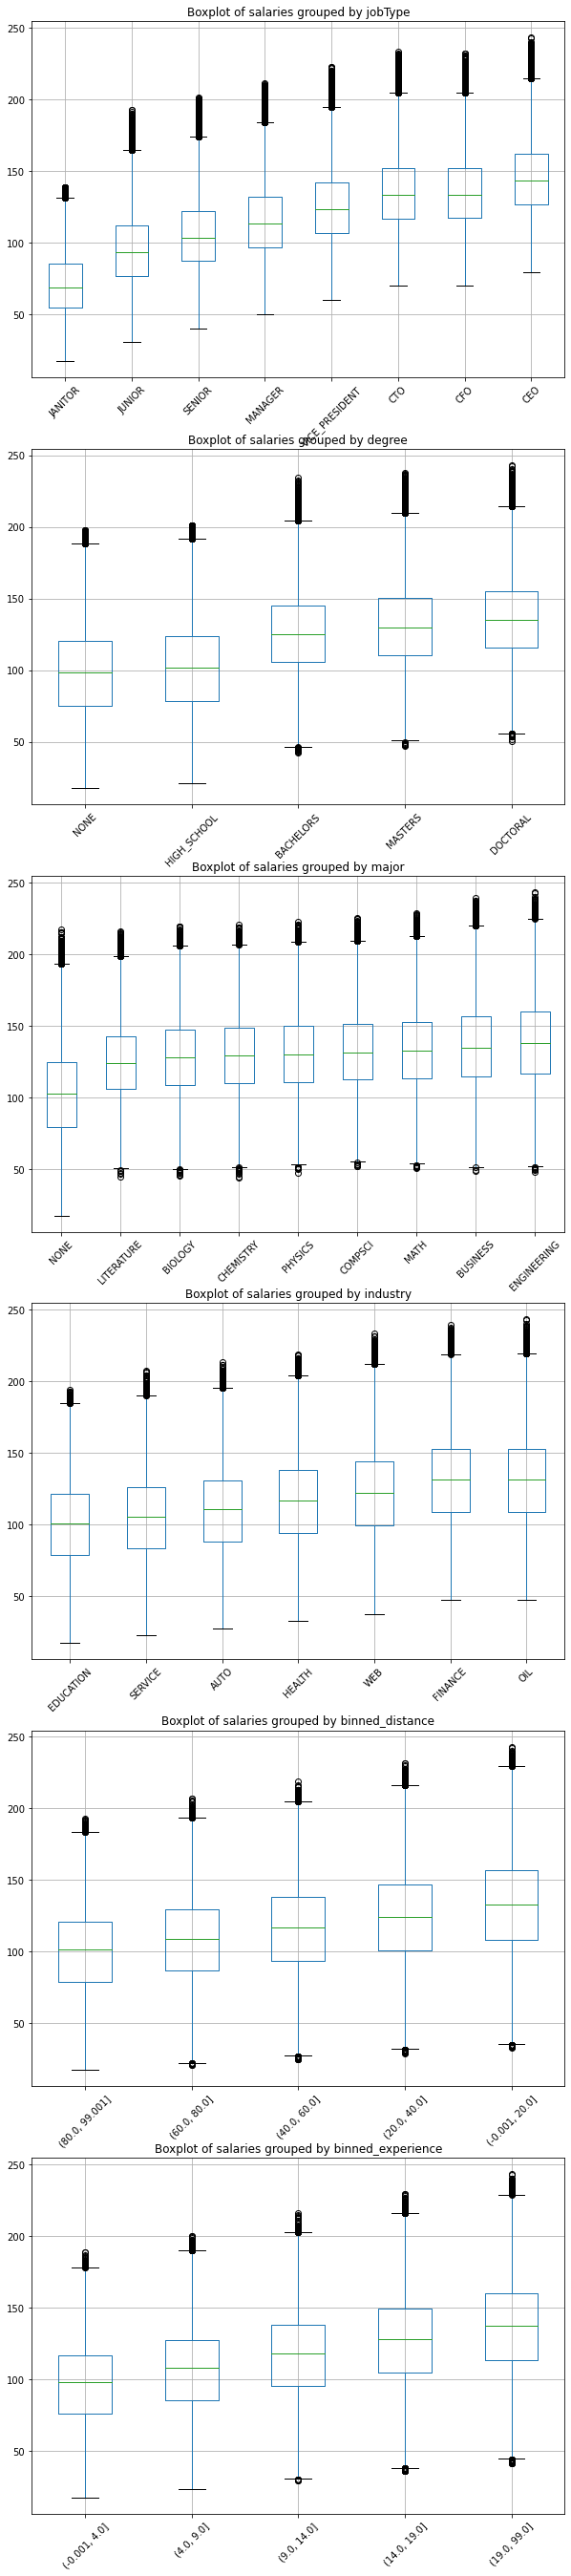

In [213]:
make_all_boxplots(full_test_df)

### Plot of model coefficients

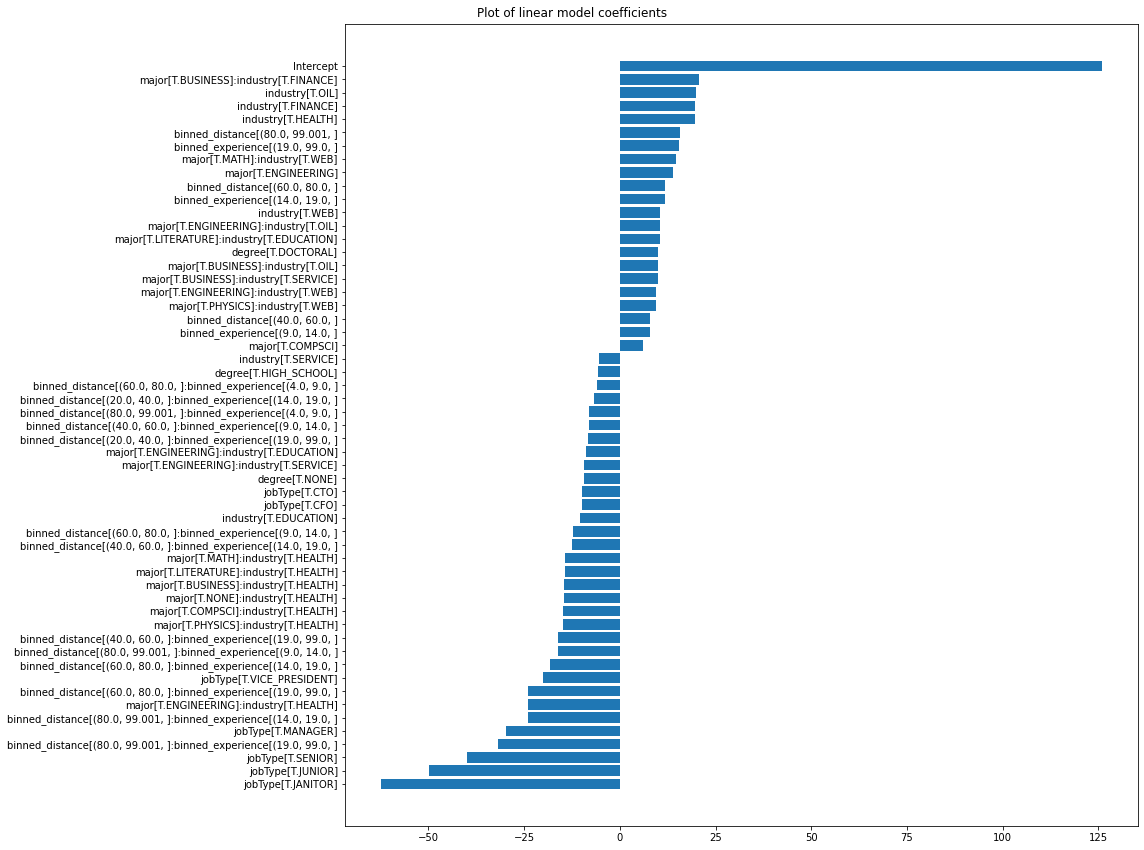

In [253]:
#transforming the summary of the linear model into a pandas dataframe
df = pd.read_html(lin_reg2f.summary().tables[1].as_html(),header=0,index_col=0)[0]
#keeping only the parameters that have a high absolute coefficient for better readability
df['important_param'] = df.coef.apply(lambda x : np.abs(x)>5)
#cleaning the index so that it takes less space
df['clean_index'] = df.index
df['clean_index'] = df['clean_index'].apply(lambda s: s.replace('T.Interval', ''))
df['clean_index'] = df['clean_index'].apply(lambda s: s.replace("closed='right')", ''))
df = df.set_index('clean_index')
#sorting values for a prettier plot
idf = df[df.important_param == True].sort_values(by= 'coef', ascending = True)
#plotting
fig = plt.figure(figsize = (16, 12))
ax = fig.add_subplot()
ax = plt.barh(idf.index, idf.coef)
fig.suptitle('Plot of linear model coefficients')
fig.tight_layout()

### Interpreting the coefficients of the final model:

The model's coefficients should be read in the following way:
- The intercept has a large positive value, of over 130. This value is higher than the mean salary for the data. This is because when the linear model defines its coefficients, it takes the first value for each category as the default value. For job types, this default value was for CEO, which explains why even CTO and CFO have a slightly negative coefficient.
- The other default values that the model took were: a bachelor's degree, a major in biology, the industry of the job is the auto industry, the job requires no experience and it is located in the metropolis.
- All other coefficients must be understood as the expected change in value when all else remains equal.

It's interesting to see that the highest positive coefficient besides the intercept was an interaction between 2 variables: having majored in business and working in the finance sector. This effect is added to the effects of having majored in business and to the effect of working in the finance sector by themselves, which means that the predicted salary for a job in the finance sector which requires a major in business is the basic prediction for that job depending on the other criteria (job type, degree, experience and distance), plus the sum of the 3 coefficients.

All of the coefficients with the largest negative value are related to job type. This is partly because job type is the most important variable (it was the variable that was used to set the baseline for prediction), but also because all of these coefficients represent the expected decrease in salary compared to a CEO position, all other things remaining equal. If the base value had been for the job type manager, job type senior would only have a slightly negative coefficient, and job type vice president would have a slightly positive one.


### Saving the final predictions

In [214]:
final_preds = full_test_df.loc[:, ['jobId', 'salary']]
final_preds.to_csv('job_predictions_final.csv')